In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1. CARGA DE DATOS ---
# Asumiendo que dentro de la carpeta 'train' está el archivo 'train.csv'
csv_path = 'petfinder-adoption-prediction/train/train.csv' 

try:
    df_full = pd.read_csv(csv_path)
    print(f"✅ Datos cargados correctamente. Total de mascotas: {len(df_full)}")
except FileNotFoundError:
    print(f"❌ ERROR: No encuentro el archivo en '{csv_path}'.")
    print("Verifica si el CSV está dentro de la carpeta 'train' o fuera.")

# --- 2. EL SPLIT (DIVISIÓN) ---
# Separamos el 20% para tu evaluación final (el examen de tu modelo).
# Usamos 'stratify' para que haya la misma proporción de adopciones rápidas/lentas en ambos lados.
train_df, test_df = train_test_split(
    df_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_full['AdoptionSpeed']
)

print("-" * 30)
print(f"📊 DATOS PARA ENTRENAR (train_df): {len(train_df)} filas")
print(f"🔒 DATOS PARA EVALUAR (test_df):  {len(test_df)} filas <- ¡No tocar hasta el final!")
print("-" * 30)

# Vistazo rápido a lo que tenemos
train_df.head(3)

✅ Datos cargados correctamente. Total de mascotas: 14993
------------------------------
📊 DATOS PARA ENTRENAR (train_df): 11994 filas
🔒 DATOS PARA EVALUAR (test_df):  2999 filas <- ¡No tocar hasta el final!
------------------------------


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
10070,1,The Adorable Trio,2,307,307,1,1,0,0,2,...,1,3,0,41326,ba248f761903dcd4c4342cc724a52145,0,These 3 puppies was rescued from a mechanic sh...,23b64fe21,8.0,2
13397,1,Perky,12,307,0,2,2,0,0,1,...,1,1,0,41326,744fa4278196568a18fcf5cd7d324ed2,0,Rescued from the dog pound. Great survivor. Ve...,6e09bfe1f,3.0,3
14656,1,Bernard Boy,2,307,307,1,1,2,7,2,...,1,1,0,41326,4d2400be2e2e78265f5c84345b7a3415,0,"Location : Teluk Intan, Perak",48a44eac5,1.0,4


In [5]:
# --- ANALISIS PREVIO A LA LIMPIEZA ---

# 1. Revisamos la cardinalidad (número de valores únicos por columna)
# Si una columna tiene 10.000 valores únicos y hay 10.000 filas, es un ID.
print("--- Valores Únicos por Variable ---")
print(train_df.nunique())

print("\n" + "-"*30 + "\n")

# 2. Revisamos los Nulos
print("--- Valores Nulos por Variable ---")
print(train_df.isnull().sum())

print("\n" + "-"*30 + "\n")

# 3. Un vistazo a las columnas de texto libre
print("--- Ejemplo de columnas de Texto ---")
print(train_df[['Name', 'Description', 'RescuerID']].head(3))

--- Valores Únicos por Variable ---
Type                 2
Name              7433
Age                103
Breed1             166
Breed2             127
Gender               3
Color1               7
Color2               7
Color3               6
MaturitySize         4
FurLength            3
Vaccinated           3
Dewormed             3
Sterilized           3
Health               3
Quantity            19
Fee                 71
State               14
RescuerID         4789
VideoAmt             9
Description      11285
PetID            11994
PhotoAmt            31
AdoptionSpeed        5
dtype: int64

------------------------------

--- Valores Nulos por Variable ---
Type                0
Name             1012
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Q

Justificación de la Selección de Características (Feature Selection)
Para establecer el modelo base (Benchmark) de Machine Learning Tabular, se ha realizado un análisis de las variables disponibles en train.csv, decidiendo excluir las siguientes por los motivos expuestos:


PetID (Identificador Único):

Análisis: Posee una cardinalidad igual al número de filas (es único para cada mascota).

Motivo de exclusión: No aporta información predictiva generalizable. El modelo podría memorizar el ID en lugar de aprender patrones, lo que lleva a un sobreajuste (overfitting) inmediato.

RescuerID (Identificador del Rescatador):

Análisis: Alta cardinalidad (miles de rescatadores distintos).

Motivo de exclusión: Aunque podría haber correlación (un rescatador hace mejores fotos que otro), incluir una variable categórica con tantos niveles dispersa la importancia del modelo. Además, el objetivo es predecir la adopción en función de las características de la mascota, no de quién la sube.

Name (Nombre de la Mascota):

Análisis: Variable de texto libre con alta cardinalidad y muchos valores nulos o genéricos ("No Name", "Kitty").

Motivo de exclusión: Para un modelo tabular numérico, el texto crudo no es procesable directamente. Aunque en una fase avanzada se podría crear una variable dummy TieneNombre (1/0), para el benchmark inicial introduce ruido innecesario.

Description (Descripción):

Análisis: Texto no estructurado de longitud variable.

Motivo de exclusión: Requiere técnicas de Procesamiento de Lenguaje Natural (NLP) como TF-IDF o Embeddings para ser útil. Dado que el objetivo de esta práctica es centrarse en la fusión de Imagen + Tabular, procesar el texto excede el alcance del bloque tabular básico.

In [6]:
# --- LIMPIEZA DE COLUMNAS ---

# Definimos las columnas a eliminar basándonos en el análisis anterior
columns_to_drop = ['Name', 'Description', 'RescuerID', 'PetID']

# Aplicamos la limpieza tanto al set de entrenamiento como al de test (importante mantener coherencia)
train_df_clean = train_df.drop(columns=columns_to_drop, axis=1)
test_df_clean = test_df.drop(columns=columns_to_drop, axis=1)

print("✅ Limpieza completada.")
print(f"Columnas restantes: {train_df_clean.columns.tolist()}")

# Verificación final de nulos
# A veces 'Age' o 'Gender' no tienen nulos, pero vale la pena asegurar.
print(f"\nTotal de nulos en el dataset limpio: {train_df_clean.isnull().sum().sum()}")

✅ Limpieza completada.
Columnas restantes: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed']

Total de nulos en el dataset limpio: 0


## 2. Modelado Base: K-Nearest Neighbors (KNN)

Antes de entrenar redes neuronales complejas, establecemos un *benchmark* usando un algoritmo clásico: **KNN**.

### Preprocesamiento Específico
Para este modelo, realizamos dos transformaciones críticas:
1.  **Separación de Features (X) y Target (y):** Aislamos `AdoptionSpeed` como nuestro objetivo.
2.  **Escalado (StandardScaler):** Dado que KNN se basa en distancias euclídeas, es sensible a la magnitud de las variables. Variables con rangos numéricos altos (como `Fee` o `Age`) dominarían la predicción sobre variables binarias. Normalizamos todo para que tenga media 0 y varianza 1.

### Configuración del Modelo
* **Algoritmo:** `KNeighborsClassifier`
* **Hiperparámetros:** `n_neighbors=5` (Estándar inicial), métrica de distancia Euclídea.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# --- 1. PREPARACIÓN DE DATOS ---

# Separamos las preguntas (X) de las respuestas (y)
X_train = train_df_clean.drop('AdoptionSpeed', axis=1)
y_train = train_df_clean['AdoptionSpeed']

# Hacemos lo mismo con el set de test (¡importante para evaluar luego!)
X_test = test_df_clean.drop('AdoptionSpeed', axis=1)
y_test = test_df_clean['AdoptionSpeed']

# --- 2. ESCALADO (OBLIGATORIO PARA KNN) ---
scaler = StandardScaler()

# "Fit" solo en train (aprender la media/desviación de los datos de entrenamiento)
# "Transform" en ambos (aplicar esa media a todo)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. ENTRENAMIENTO KNN ---
print("⏳ Entrenando KNN (esto puede tardar unos segundos)...")
knn = KNeighborsClassifier(n_neighbors=5) # Probamos con 5 vecinos
knn.fit(X_train_scaled, y_train)

# --- 4. PREDICCIÓN Y EVALUACIÓN ---
print("🔮 Prediciendo sobre el set de Test...")
y_pred = knn.predict(X_test_scaled)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy (Exactitud) del KNN: {acc:.4f}")
print("\n--- Informe de Clasificación ---")
print(classification_report(y_test, y_pred))

⏳ Entrenando KNN (esto puede tardar unos segundos)...
🔮 Prediciendo sobre el set de Test...

✅ Accuracy (Exactitud) del KNN: 0.3161

--- Informe de Clasificación ---
              precision    recall  f1-score   support

           0       0.11      0.06      0.08        82
           1       0.26      0.34      0.29       618
           2       0.30      0.35      0.32       807
           3       0.30      0.24      0.27       652
           4       0.44      0.35      0.39       840

    accuracy                           0.32      2999
   macro avg       0.28      0.27      0.27      2999
weighted avg       0.33      0.32      0.32      2999



## 3. Modelo Avanzado: Random Forest

Para superar las limitaciones del KNN, implementamos un **Random Forest**. Este algoritmo es ideal para datos tabulares heterogéneos (mezcla de categorías y números) y ofrece ventajas clave para nuestro análisis.

### Justificación de la Elección
1.  **Robustez:** Al promediar cientos de árboles de decisión, reduce la varianza y el riesgo de *overfitting* comparado con un solo árbol.
2.  **Manejo de Características:** No requiere escalado de datos (es invariante a la escala monotónica) y maneja bien las interacciones no lineales entre variables (ej: "Si es Perro Y es Joven").
3.  **Interpretabilidad:** Nos permite extraer la **"Feature Importance"**, cuantificando qué variables (Edad, Precio, Raza) influyen más en la velocidad de adopción.

### Configuración
* **n_estimators:** 100 árboles (equilibrio entre rendimiento y coste computacional).
* **random_state:** 42 (para reproducibilidad de resultados).

🌲 Entrenando Random Forest (100 árboles)...
🔮 Prediciendo...

✅ Accuracy Random Forest: 0.3868
(Mejora respecto al KNN: 7.07%)

--- Informe de Clasificación (Random Forest) ---
              precision    recall  f1-score   support

           0       0.27      0.09      0.13        82
           1       0.33      0.34      0.34       618
           2       0.34      0.34      0.34       807
           3       0.36      0.27      0.31       652
           4       0.48      0.58      0.52       840

    accuracy                           0.39      2999
   macro avg       0.36      0.32      0.33      2999
weighted avg       0.38      0.39      0.38      2999



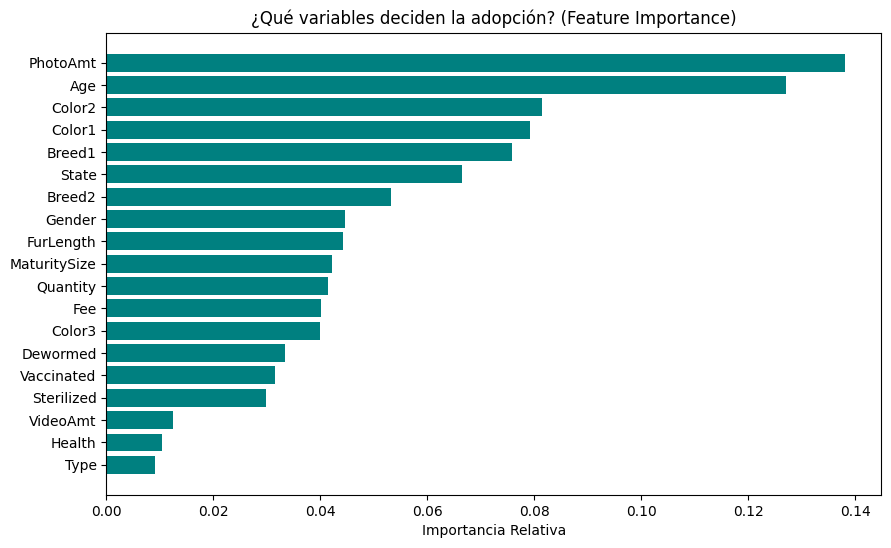

In [8]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. ENTRENAMIENTO ---
# Nota: Random Forest NO necesita datos escalados, usamos los originales X_train / X_test
print("🌲 Entrenando Random Forest (100 árboles)...")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train) # Usamos X_train (sin escalar) del paso anterior

# --- 2. EVALUACIÓN ---
print("🔮 Prediciendo...")
y_pred_rf = rf_model.predict(X_test)

# Métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n✅ Accuracy Random Forest: {acc_rf:.4f}")
print("(Mejora respecto al KNN: {:.2f}%)".format((acc_rf - acc) * 100))

print("\n--- Informe de Clasificación (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

# --- 3. IMPORTANCIA DE VARIABLES (CRUCIAL PARA EL INFORME) ---
# Extraemos qué variables han sido más útiles para el modelo
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Creamos un DataFrame para ordenarlas
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color='teal')
plt.xlabel("Importancia Relativa")
plt.title("¿Qué variables deciden la adopción? (Feature Importance)")
plt.gca().invert_yaxis() # Para que la más importante salga arriba
plt.show()